<a href="https://colab.research.google.com/github/supertime1/BP_PPG/blob/master/Data%20Processing/BP_Data_Clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.Introduction

This notebook processes the ABP and PPG signals from MIMIC-III waveform database.
(https://archive.physionet.org/physiobank/database/mimic3wdb/matched/ ）


The output of this notebook are PPG signals with 60s segements at 125 Hz, with systolic and diastolic BP W/O heart rate as numeric labels. The output data will be used to train a PPG based blood pressure model in BP_PPG_CNN+LSTM or Attention_model notebook.


The data cleaning and preprocessing is summarized into the following workflow:
\
\
![workflow](https://drive.google.com/uc?export=view&id=1SgGpoB_asuzQTKdxVyUIugGFgmahGOFX)


#2.Setup Environment

In [1]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import wfdb
import sklearn
from sklearn import preprocessing
import io
import pickle
import numba
from numba import jit
import tensorflow as tf
from scipy.signal import find_peaks

#3.Mine ABP and PPG data from WFDB

##3.1 Extract filenames

In [ ]:
#filter out files smaller than 17Kb
hd_names = []
for name in glob.glob("D:/WFDB//matched/p*/*/[0-9]*[!layout][!n].dat"):
  if os.path.getsize(name) < 17*1024:
    continue
  position = name.index('.')
  name = name[0:position] #remove the .hea part to comply the wfdb.rdrecord format
  hd_names.append(name)
print("There are total ", len(hd_names), "records that are bigger than 17kb")

There are total  363716 records that are bigger than 17kb


In [ ]:
#extract ABP and PPG from filtered files
qualified_names = [] #a list of file names that contain both PPG and ABP waveforms
for name in hd_names:
  record = wfdb.rdheader(name)
  if 'ABP' in record.sig_name and 'PLETH' in record.sig_name and record.sig_len >= 75000: #only extract records contrains ABP and PPG, and >=10min
    qualified_names.append(name)
print('There are total', len(qualified_names), 'records that have both ABP and PPG with more than 10min recording')

with open('D:/WFDB//matched/BP/qualified_names.pkl', "wb") as fp:
  pickle.dump(qualified_names, fp)

There are total 54440 records that have both ABP and PPG with more than 10min recording


##3.2 Mine data

In [ ]:
def date_id(filename):
  """
  This function extract patient ID and the data collection date for that specific file
  
  Arguments:
  filename -- a single file from qualified filenames
  
  Returns:
  s_id -- subject id of the input file
  r_date -- date collection date of the input file
  record_name -- record name of the input file
  """   
  fn_seg = filename.split('\\')
  #extract subject ID
  s_id = fn_seg[2]
  #extract signal collected date
  record_name = fn_seg[3]
  subdir = fn_seg[0] + '/' + fn_seg[1] + '/' + fn_seg[2] + '/'
  
  #read header files
  records =[]
  for name in glob.glob(subdir + 'p*[!n].hea'):
    position = name.index('.')
    name = name[0:position]
    record = wfdb.rdheader(name)
    records.append(record)
  #extract signal collected date
  receive_date = None
  for record in records:
    if record_name in record.seg_name:
      receive_date = record.base_date
  r_date = str(receive_date)

  return s_id, r_date, record_name

In [ ]:
def mine_data(qualified_names, directory, patient = True):
  """
    Mine data from qualified files(>17kb and with both ABP and PPG signals).It is
    worth noting that 1 Patient could have multipe records collected at different 
    dates. 
    
    It will take several hours to finish running this function, plz be patient :)
    
    Arguments:
    qualified_names -- qualified filenames (>17kb and with both ABP and PPG signals) from 3.1 
    directory -- directory to save the output of mine_data
    patient -- save to filename with subject id and subject received date if patient = True; 
               otherwise, save data for every 500 records
    
    Returns:
    files with ABP and PPG signals (EITHER each file contains 500 records if patient=FALSE, 
     OR each file with filename subject id and received date, if patient = TRUE). 

  """
  if patient == True:
    for name in qualified_names:
      record = wfdb.rdrecord(name)
      ABP_index = record.sig_name.index('ABP')
      PPG_index = record.sig_name.index('PLETH')
      ABP_sig = record.p_signal.T[ABP_index]
      PPG_sig = record.p_signal.T[PPG_index]

      if np.isnan(ABP_sig).any() or np.isnan(PPG_sig).any(): ##remove signal with NA
        continue
      
      #extact Subject ID and data collection date
      s_id, r_date, r_name = date_id(name)

      with open(directory + 'ABP_signals_'+ r_name + '_' + s_id + '_' + r_date + '.pkl', "wb") as fp:
        pickle.dump(ABP_sig, fp)
      #save PPG data of previous id
      with open(directory + 'PPG_signals_'+ r_name + '_' + s_id + '_' + r_date + '.pkl', "wb") as fp:
        pickle.dump(PPG_sig, fp)
  
  #if patient != true
  else:
    ABP_signals = [] #create a  list to store all  ABP signals
    PPG_signals = [] #create a  list to store all  PPG signals
    n=0
    for name in qualified_names:
      record = wfdb.rdrecord(name)
      ABP_index = record.sig_name.index('ABP')
      PPG_index = record.sig_name.index('PLETH')
      ABP_sig = record.p_signal.T[ABP_index]
      PPG_sig = record.p_signal.T[PPG_index]

      if np.isnan(ABP_sig).any() or np.isnan(PPG_sig).any(): ##remove list with all empty signals
        continue
      else:
        ABP_signals.append(ABP_sig)
        PPG_signals.append(PPG_sig)
        n+=1
      
      #for every 500 samples, save to disk to release the RAM space
      if n%100 == 0:
        print("saving data No." + str(n//100))
        #save ABP data
        with open(directory + 'ABP_signals_'+str(n//100)+'.pkl', "wb") as fp:
          pickle.dump(ABP_signals, fp)
        #save PPG data
        with open(directory + 'PPG_signals_'+str(n//100)+'.pkl', "wb") as fp:
          pickle.dump(PPG_signals, fp)
        #clear up space in the list
        ABP_signals.clear()
        PPG_signals.clear()

      else:
        continue
    
      #save the last <100 ABP data
      with open(directory + 'ABP_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
        pickle.dump(ABP_signals, fp)
      #save the last <500 PPG data
      with open(directory + 'PPG_signals_'+str(n//100 + 1)+'.pkl', "wb") as fp:
        pickle.dump(PPG_signals, fp)

  return None

In [ ]:
directory = 'D:/WFDB//matched/BP/'
mine_data(qualified_names, directory, patient=True)

#4.Process PPG and ABP raw data

In [47]:
with open('D:/WFDB//matched/BP/Data Mining/Original Data - Patient/PPG_signals_3003031_0011_p073429_2133-05-24.pkl', "rb") as fp:
  PPG_raw_signals = pickle.load(fp)
with open('D:/WFDB//matched/BP/Data Mining/Original Data - Patient/ABP_signals_3003031_0011_p073429_2133-05-24.pkl', "rb") as fp:
  ABP_raw_signals = pickle.load(fp)

C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


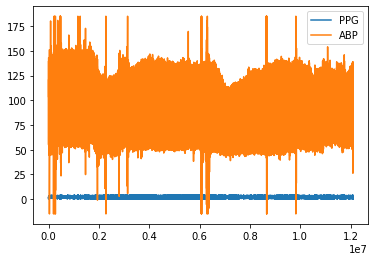

In [49]:
plt.plot(PPG_raw_signals,label="PPG")
plt.plot(ABP_raw_signals,label="ABP")
plt.legend()

##4.1 Flat line removal

To remove the flatline of a record: if 10% of the signals are made of flatline, then the entire record is removed. The flatline is defined as the change of consecutive points is smaller than a pre-defined threshold. In this notebook, the threshold has been set to 0, whereas a more reasonable value would come from histgram analysis of consecutive point differnce.


In [50]:
def flat_line(signals,threshold = 0, percent = .10):
  """
    This function removes records that has flat_line region more than specified
    percentage of the record.
    
    Arguments:
    signals -- a list of raw PPG or ABP signal record (each with different length)
    threshold -- flat points definition threshold
    percent- - the flat_line region is more than this percentage, the entire/
               record will be removed
    
    Returns:
    clean_signals -- a list of cleaned signals after flat_line records have been removed
    rm_list -- a list of index (of input signals) of removed signals

   """
  
  clean_signals = []
  #create a list to store the index of the removed segments, this will be used
  #to remove the PPG signals with same index
  rm_list = []
  for i in range(len(signals)):
    #use np.diff to find consecutive points: diff = [i] - [i+1]
    signal_diff = np.diff(signals[i])
    #change value less than threshold to 0, and the rest to 1
    less = np.abs(signal_diff) <= threshold
    more = np.abs(signal_diff) > threshold
    signal_diff[less] = 0
    signal_diff[more] = 1
    #calculate what percent of 0 in the signal, remove the entire signal if 
    #percentage is higher than defined percent
    zero_per = np.sum(signal_diff==0)/len(signal_diff)
    if zero_per < percent:
      clean_signals.append(signals[i])
    else:
      rm_list.append(i)
    
    #track the progress for impatient programmer
    #if i%10000 == 0:
      #print("Processing on", i, "th sample")

  return clean_signals,rm_list

###4.1.1 PPG flat line removal

In [ ]:
PPG_clean_signals,PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)

In [ ]:
print('There are',len(PPG_clean_signals),'accepted PPG segments')
print('There are',len(PPG_rm_list),'rejected PPG segements that have flat line region more than ~10%')

There are 9 accepted PPG segments
There are 0 rejected PPG segements that have flat line region more than ~10%


In [ ]:
#take the fist 100 samples to see the rejected segements
for i in range(len(PPG_rm_list[:50])):
  x = PPG_rm_list[i]
  plt.figure()
  plt.plot(PPG_raw_signals[x])

###4.1.2 ABP flat line removal

In [ ]:
ABP_clean_signals,ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)

In [ ]:
print('There are',len(ABP_clean_signals),'accepted ABP segments')
print('There are',len(ABP_rm_list),'rejected ABP segements that have flat line region more than ~12%')

There are 9 accepted ABP segments
There are 0 rejected ABP segements that have flat line region more than ~12%


In [ ]:
#take the fist 100 samples to see the rejected segements
for i in range(len(ABP_rm_list[:100])):
  x = ABP_rm_list[i]
  plt.figure()
  plt.plot(ABP_raw_signals[x])

###4.1.3 Remove flat ABP and PPG 


In [ ]:
#join the two lists rm_list from ABP, and PPG_rm_list
ABP_list = pd.DataFrame(ABP_rm_list)
PPG_list = pd.DataFrame(PPG_rm_list)
try:
  total_list = ABP_list.merge(PPG_list,how="outer")
except:
  total_list = pd.concat([ABP_list,PPG_list],axis=0)
print('There are in total',len(total_list),"flat line segments in the joint list")

There are in total 0 flat line segments in the joint list


In [ ]:
ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)
print('There are in total',len(ABP_cl_signals),"accepted ABP segments")
print('There are in total',len(PPG_cl_signals),"accepted PPG segments")

There are in total 9 accepted ABP segments
There are in total 9 accepted PPG segments


##4.2 Segmentation

###4.2.1 Turn records into 1min segs

In [51]:
def generate_segment_data(source,seg_len, list_type = True):
  """
    This function segement each record into a list of 1min signals
    
    Arguments:
    source -- records that have a flat line less than 10% or other predefined threshold
    seg_len -- the lenght of the output signal, for 125Hz sampling rate data, seg_len
               is set to be 125 * 60 = 7500 for 1 min output
    list_type -- source data will be list if mine_data(Patient = True), if source data is processed 
                 from mine_data(Patient = True), set this to False
    Returns:
    signals --  a list of 1 mins signals from each records

   """
  signals =[]

  if list_type == True:
    for signal in source:
      for i in range(int(len(signal)/seg_len)):
        seg = signal[seg_len*i:seg_len*(i+1)]
        signals.append(seg)

  else:
    for i in range(int(len(source)/seg_len)):
      seg = source[seg_len*i:seg_len*(i+1)]
      signals.append(seg)
  #convert list into a numpy array and change its dim from (num of records, seg_len, 1) to (num of records, seg_len)  
  signals = np.asarray(list(map(lambda x: np.reshape(x,seg_len),signals)))

  return signals

In [52]:
ABP_seg_signals = generate_segment_data(ABP_raw_signals, 7500, list_type=False)
print('ABP segmented signals dim:', ABP_seg_signals.shape)

ABP segmented signals dim: (1612, 7500)


In [53]:
PPG_seg_signals = generate_segment_data(PPG_raw_signals, 7500, list_type=False)
print('PPG segmented signals dim:', PPG_seg_signals.shape)

PPG segmented signals dim: (1612, 7500)


###4.2.2 Apply flat_line on seg level

In [54]:
#lower tolerance for ABP since this will be used to generate ground truth
ABP_seg_clean_signals,ABP_seg_rm_list = flat_line(ABP_seg_signals,0,percent=0.02)

In [55]:
#higher tolerance for PPG since the DL algorithm needs to have some robustness
PPG_seg_clean_signals,PPG_seg_rm_list = flat_line(PPG_seg_signals,0,percent=0.05)

In [56]:
#join the two lists rm_list from ABP, and PPG_rm_list
ABP_seg_list = pd.DataFrame(ABP_seg_rm_list)
PPG_seg_list = pd.DataFrame(PPG_seg_rm_list)
try:
  total_seg_list = ABP_seg_list.merge(PPG_seg_list,how="outer")
except:
  total_seg_list = pd.concat([ABP_seg_list,PPG_seg_list],axis=0)
print('There are in total',len(total_seg_list),"flat line segments in the joint list")

There are in total 523 flat line segments in the joint list


In [57]:
ABP_seg_cl_signals = np.delete(ABP_seg_signals,total_seg_list,0)
PPG_seg_cl_signals = np.delete(PPG_seg_signals,total_seg_list,0)
print('There are in total',len(ABP_seg_cl_signals),"accepted ABP segments")
print('There are in total',len(PPG_seg_cl_signals),"accepted PPG segments")

There are in total 1089 accepted ABP segments
There are in total 1089 accepted PPG segments


##4.3 Process ABP data

###4.3.1 Peak Segmentation

Do another segementation for ABP based on each peak (i.e. segement 1min signals into each heart beat cycle)



In [58]:
def peak_segmentation(signal,distance = 50):
  """
  This function segement each ABP 1min signal into heart beats by using 
  peak detetion algorithm

  Arguments:
  signal -- 1 min ABP singal
  distance -- minium peak-to-peak seperation distance (50 means 50 data points)

  Returns:
  segments --  a list of 1 min heart beats

  """
  valleys, _ = find_peaks(signal*-1, distance=distance)
  
  segments = []
  for i in range(len(valleys)-1):
    seg = signal[valleys[i]:valleys[i+1]]
    segments.append(seg)
  
  return segments

In [59]:
ABP_ps_signals = [peak_segmentation(i) for i in ABP_seg_cl_signals]
print('ABP 1min segmented signals dim:', ABP_seg_cl_signals.shape)
print('ABP cycle segmented signals no. of samples:(',len(ABP_ps_signals),', No.of cycles, No.of points/cycle)')

ABP 1min segmented signals dim: (1089, 7500)
ABP cycle segmented signals no. of samples:( 1089 , No.of cycles, No.of points/cycle)


###4.3.2 Flat peak removal

In [60]:
def flat_peak(cycles, tolerance = 1):
  """
  This function removes heat beat cycles (in 1 min) that have flat peaks

  Arguments:
  cycles -- 1 min ABP signals that consisits many heart beat cycles
  tolerance -- number of acceptable flat point 

  Returns:
  clean_cycles --  a list of cleaned heat beat cycles

  """  
  clean_cycles = []

  for i in range(len(cycles)):
    if len(np.argwhere(cycles[i] == np.amax(cycles[i]))) > tolerance:
      continue;
    else: 
      clean_cycles.append(cycles[i])

  return clean_cycles

In [61]:
def flat_peak_remove(signals, seg_ratio = 0.95, tolerance = 1):
  """
  This function removes 1min segements that have flat peak

  Arguments:
  signals -- A list of 1min ABP signals that are represented by 
             dim [No.of 1min records, No.of heart beats in 1 min, No. of points in each heart beat ]
  seg_ratio -- threhold to remove the whole 1min signal (i.e. if the ratio of 
                "No. of cleaned flat peak heart beat cycles"/"No. of original 1min heart beat cycles" 
                is less than this treshold, then the whole 1min signal of cycles will be removed )
  Returns:
  cleaned_segments --  a list of cleaned 1min signals
  remove_index --  list of index (of input signals) removed 1min signals

  """  
  clean_segments = []
  remove_index = [] 

  for i in range(len(signals)):
    #in case some lists are empty
    if signals[i] == []: 
      remove_index.append(i) 
      continue  

    clean_cycles = flat_peak(signals[i],tolerance)
    
    if len(clean_cycles)/(len(signals[i])) < seg_ratio: 
      remove_index.append(i)
      continue
    
    clean_segments.append(clean_cycles)

  return clean_segments, remove_index

In [62]:
ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.95,1)

In [63]:
print('ABP 1min segmented signals that has more than 10% cycles has flat peak:', len(remove_index))
print('Cleaned ABP 1min segmented signals:', len(ABP_fpr_signals))

ABP 1min segmented signals that has more than 10% cycles has flat peak: 917
Cleaned ABP 1min segmented signals: 172


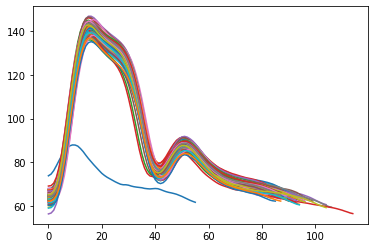

In [64]:
#plot to see what have been removed
for i in range(len(ABP_ps_signals[remove_index[5]])):
  plt.figure
  plt.plot(ABP_ps_signals[remove_index[5]][i])

In [ ]:
#plot to see the cleaned signals
for i in range(len(ABP_fpr_signals[4])):
  plt.plot(ABP_fpr_signals[4][i])

###4.3.3 Remove PPG data

Remove PPG data that overlaps with ABP remove_index, since no ground truth BP value can be generated for those PPG data

In [65]:
PPG_fpr_signals = np.delete(PPG_seg_cl_signals,remove_index,0)
print('There are in total',len(ABP_fpr_signals),"accepted ABP 1min segments")
print('There are in total',len(PPG_fpr_signals),"accepted PPG 1min segments")

There are in total 172 accepted ABP 1min segments
There are in total 172 accepted PPG 1min segments


###4.3.4 Generate ground truth

In [66]:
def bp_ground_truth(signals, tolerance = 15, return_hr = True):
  """
  This function returns average systolic and diastolic value of a 1min signals

  Arguments:
  signals -- A list of 1min ABP signals that are represented by 
             dim [No.of 1min records, No.of heart beats in 1 min, No. of points in each heart beat ]
  seg_ratio -- threhold to remove the whole 1min signal (i.e. if the ratio of 
                "No. of cleaned flat peak heart beat cycles"/"No. of original 1min heart beat cycles" 
                is less than this treshold, then the whole 1min signal of cycles will be removed)
  return_hr -- set it to True to get the heart rate of each 1min signals
  
  Returns:
  gt_ls --  a list of BP (and HR if return_hr == True) for a list of 1min signals
  remove_index --  list of index (of input signals) of removed 1min signals

  """  
  gt_ls = []
  remove_index = []
  for i in range(len(signals)):
    cycles = signals[i]    #a list of cycles in 1min signal
    
    cyc_sys_list = []
    cyc_dia_list = []
    for j in range(len(cycles)):
      cyc_sys_list.append(max(cycles[j]))
      cyc_dia_list.append(cycles[j][0])

    if np.max(np.asarray(cyc_sys_list)) - np.min(np.asarray(cyc_sys_list)) > tolerance \
    or np.max(np.asarray(cyc_dia_list)) - np.min(np.asarray(cyc_dia_list)) > tolerance:
      remove_index.append(i)
      continue

    else: 
      if return_hr == True:
        gt_ls.append([np.average(np.asarray(cyc_sys_list)),
                  np.average(np.asarray(cyc_dia_list)), len(cyc_sys_list)])

      else:
        gt_ls.append([np.average(np.asarray(cyc_sys_list)),
                  np.average(np.asarray(cyc_dia_list))])
  
  return gt_ls, remove_index

In [67]:
gt_ls, gt_rm_ls = bp_ground_truth(ABP_fpr_signals, 15)
print("Ground truth list has", len(gt_ls), "samples")

Ground truth list has 30 samples


In [68]:
PPG_gt_signals = np.delete(PPG_fpr_signals,gt_rm_ls,0)
ABP_gt_signals = np.delete(ABP_fpr_signals,gt_rm_ls,0)
print('There are in total',len(gt_ls),"accepted ABP labels")
print('There are in total',len(PPG_gt_signals),"accepted PPG 1min segments")

There are in total 30 accepted ABP labels
There are in total 30 accepted PPG 1min segments


C:\Users\57lzhang.US04WW4008\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
for n in range(len(ABP_gt_signals)):
  plt.figure()
  for i in range(len(ABP_gt_signals[n])):
    plt.plot(ABP_gt_signals[n][i])

##4.4 Process PPG raw data
Only do scaling(standardization), bandpass and hempal on PPG signals, not on ABP, since APB's waveform will be the groundtruth for blood pressure.

###4.4.1 Scaling

In [70]:
#use robust_scale instead of scale to leave out outliers
PPG_norm_signals = [sklearn.preprocessing.robust_scale(i) for i in PPG_gt_signals]
print("After re-scaling, there are:", len(PPG_norm_signals), "PPG records")

After re-scaling, there are: 30 PPG records


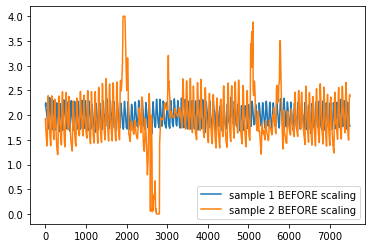

In [71]:
plt.plot(PPG_gt_signals[0],label="sample 1 BEFORE scaling")
plt.plot(PPG_gt_signals[10],label="sample 2 BEFORE scaling")
plt.legend()

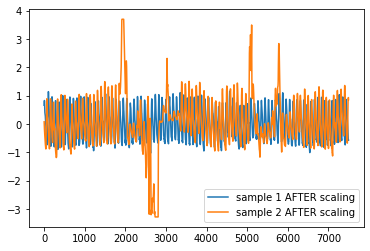

In [72]:
plt.plot(PPG_norm_signals[0],label="sample 1 AFTER scaling")
plt.plot(PPG_norm_signals[10],label="sample 2 AFTER scaling")
plt.legend()

###4.4.2 Band pass filter



In [73]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [75]:
PPG_bf_signals =[butter_bandpass_filter(i,0.5,8,125,order=4) for i in PPG_norm_signals]
print("After band pass filtering, there are:", len(PPG_bf_signals), "PPG records")

After band pass filtering, there are: 30 PPG records


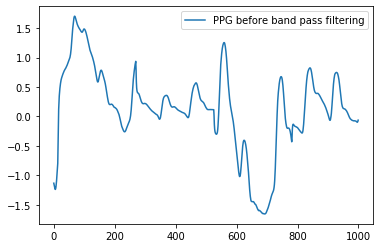

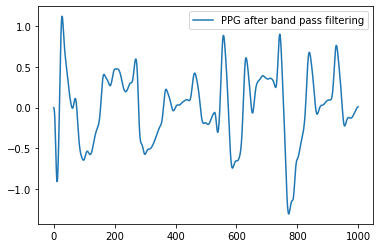

In [76]:
plt.plot(PPG_norm_signals[28][:1000],label="PPG before band pass filtering")
plt.legend()
plt.figure()
plt.plot(PPG_bf_signals[28][:1000], label="PPG after band pass filtering")
plt.legend()

###4.4.3 Hampel filter

The efffectiveness of hampel filter depends on how we play the two parameters: window_size and number of sigmas. 

In [77]:
#use numba to improve the speed of for loop
@jit(nopython=True)
def hampel_filter_forloop_numba(input_series, window_size, n_sigmas=3):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    #indices = []
    
    for i in range((window_size),(n - window_size)):
        x0 = np.nanmedian(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.nanmedian(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            #indices.append(i)
    
    return new_series#, indices

In [78]:
PPG_hf_signals = [hampel_filter_forloop_numba(i, 6) for i in PPG_bf_signals]
print("After Hample filtering, there are:", len(PPG_hf_signals), "PPG segments")

After Hample filtering, there are: 30 PPG segments


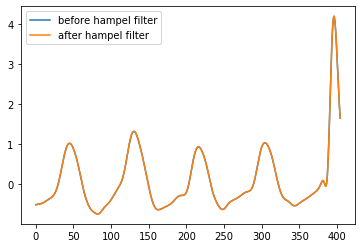

In [79]:
plt.plot(PPG_bf_signals[1][400:805], label = "before hampel filter")
plt.plot(PPG_hf_signals[1][400:805], label = "after hampel filter")
plt.legend()

# 5.Applied above steps to all data

##5.1 process_data function

In [ ]:
def process_data(input_dir, output_dir):
  """
  This function applies above steps to the output of mine_data(Patient = FALSE). 
  In other words, the data will be processed without knowing the patient information.
  
  Arguments:
  input_dir -- where the input data from mine_data is saved 
  output_dir -- where to save the output data of this function

  Returns:
  A processed PPG data and Ground Truth labels

  """  

  #load data
  ABP_names = glob.glob(input_dir + "ABP*.pkl")
  PPG_names = glob.glob(input_dir + "PPG*.pkl")
  assert(len(ABP_names) == len(PPG_names))
  for i in range(len(ABP_names)):
    
    print("processing", i, "th data")

    with open(ABP_names[i], "rb") as fp:
      ABP_raw_signals = pickle.load(fp)

    with open(PPG_names[i], "rb") as fp:
      PPG_raw_signals = pickle.load(fp)


    #remove flat lines on record level: ABP: 10%, PPG: 10%
    _, PPG_rm_list = flat_line(PPG_raw_signals,0,percent=0.10)
    _, ABP_rm_list = flat_line(ABP_raw_signals,0,percent=0.10)
    
    ABP_list = pd.DataFrame(ABP_rm_list)
    PPG_list = pd.DataFrame(PPG_rm_list)

    try:
      total_list = ABP_list.merge(PPG_list,how="outer")
    except:
      total_list = pd.concat([ABP_list,PPG_list],axis=0)
      
    ABP_cl_signals = np.delete(ABP_raw_signals,total_list,0)
    PPG_cl_signals = np.delete(PPG_raw_signals,total_list,0)  

    #segment into 1min data
    ABP_seg_signals = generate_segment_data(ABP_cl_signals, 7500)
    PPG_seg_signals = generate_segment_data(PPG_cl_signals, 7500)

    #remove flat lines on 1min segment level: ABP: 2%, PPG: 5%
    _, ABP_seg_rm_list = flat_line(ABP_seg_signals,0,percent=0.02)
    _, PPG_seg_rm_list = flat_line(PPG_seg_signals,0,percent=0.05)

    ABP_seg_list = pd.DataFrame(ABP_seg_rm_list)
    PPG_seg_list = pd.DataFrame(PPG_seg_rm_list)

    try:
      total_seg_list = ABP_seg_list.merge(PPG_seg_list,how="outer")
    except:
      total_seg_list = pd.concat([ABP_seg_list,PPG_seg_list],axis=0)
    
    ABP_seg_cl_signals = np.delete(ABP_seg_signals,total_seg_list,0)
    PPG_seg_cl_signals = np.delete(PPG_seg_signals,total_seg_list,0)

    #PROCESS ABP SIGNAL
    #1.peak segmentation: distance = 50
    ABP_ps_signals = [peak_segmentation(i, distance = 50) for i in ABP_seg_cl_signals]
    #2.flat peak removal: seg_ratio = 0.95, tolerance = 1
    ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.95,1)
    #3.remove corresponding PPG signal
    PPG_fpr_signals = np.delete(PPG_seg_cl_signals,remove_index,0)
    #4.generate ground truth ABP: tolerance = 15 mmHg
    gt_ls, gt_rm_list= bp_ground_truth(ABP_fpr_signals, tolerance=15, return_hr = True)
    #5.remove corresponding PPG signals
    PPG_gt_signals = np.delete(PPG_fpr_signals,gt_rm_list,0)

    #PROCESS PPG SIGNAL
    #1.standardize PPG signal
    PPG_norm_signals = [sklearn.preprocessing.robust_scale(i) for i in PPG_gt_signals]
    #2.band pass filter on PPG sinal
    PPG_bf_signals =[butter_bandpass_filter(i,0.5,8,125,order=4) for i in PPG_norm_signals]
    #3. hampel filter
    PPG_hf_signals = [hampel_filter_forloop_numba(i, 6) for i in PPG_bf_signals]
    #4. resample signal
    ##PLACEHOLDER for resampling signal to a lower frequency, if needed
    with open(output_dir + "BP_data" + "_" + str(i), "wb") as fp:
      pickle.dump(PPG_hf_signals,fp)

    with open(output_dir + "BP_label" + "_" + str(i), "wb") as fp:
      pickle.dump(gt_ls,fp)

  return None

In [ ]:
input_dir = 'D:/WFDB//matched/BP/'
output_dir = 'D:/WFDB//matched/BP/'
process_data(input_dir, output_dir)

##5.2 new_process_data function

In [80]:
def new_process_data(input_dir, output_dir):
  """
  This function applies to the output of mine_data(Patient = TRUE). 
  In other words, we would like to keep subject ID during data processing, 
  so that we can input patients' biometrics later during modeling. One nuance is
  that new_process_data function removes the record level flat line removal step
  
  Arguments:
  input_dir -- where the input data from mine_data(Patient = TRUE) is saved 
  output_dir -- where to save the output data of this function
  
  Returns:
  A processed PPG data and Ground Truth labels

  """ 

  #load data
  ABP_names = glob.glob(input_dir + "Data Mining/Original Data - Patient/ABP*.pkl")
  PPG_names = glob.glob(input_dir + "Data Mining/Original Data - Patient/PPG*.pkl")
  assert(len(ABP_names) == len(PPG_names))
  for i in range(len(ABP_names)):
    
    print("processing", i, "th data")

    with open(ABP_names[i], "rb") as fp:
      ABP_raw_signals = pickle.load(fp)

    with open(PPG_names[i], "rb") as fp:
      PPG_raw_signals = pickle.load(fp)

    
    #segment into 1min data
    ABP_seg_signals = generate_segment_data(ABP_raw_signals, 7500, list_type = False)
    PPG_seg_signals = generate_segment_data(PPG_raw_signals, 7500, list_type = False)

    #remove flat lines on 1min segment level: ABP: 2%, PPG: 5%
    _, ABP_seg_rm_list = flat_line(ABP_seg_signals,0,percent=0.02)
    _, PPG_seg_rm_list = flat_line(PPG_seg_signals,0,percent=0.05)

    ABP_seg_list = pd.DataFrame(ABP_seg_rm_list)
    PPG_seg_list = pd.DataFrame(PPG_seg_rm_list)

    try:
      total_seg_list = ABP_seg_list.merge(PPG_seg_list,how="outer")
    except:
      total_seg_list = pd.concat([ABP_seg_list,PPG_seg_list],axis=0)
    
    ABP_seg_cl_signals = np.delete(ABP_seg_signals,total_seg_list,0)
    PPG_seg_cl_signals = np.delete(PPG_seg_signals,total_seg_list,0)

    #PROCESS ABP SIGNAL
    #1.peak segmentation: distance = 50
    ABP_ps_signals = [peak_segmentation(i, distance = 50) for i in ABP_seg_cl_signals]
    #2.flat peak removal: seg_ratio = 0.95, tolerance = 1
    ABP_fpr_signals, remove_index = flat_peak_remove(ABP_ps_signals,0.95,1)
    #3.remove corresponding PPG signal
    PPG_fpr_signals = np.delete(PPG_seg_cl_signals,remove_index,0)
    #4.generate ground truth ABP and HR: tolerance = 15 mmHg
    gt_ls, gt_rm_list= bp_ground_truth(ABP_fpr_signals, tolerance=15, return_hr = True)
    #5.remove corresponding PPG signals
    PPG_gt_signals = np.delete(PPG_fpr_signals,gt_rm_list,0)

    #PROCESS PPG SIGNAL
    #1.standardize PPG signal
    PPG_norm_signals = [sklearn.preprocessing.robust_scale(i) for i in PPG_gt_signals]
    #2.band pass filter on PPG sinal
    PPG_bf_signals =[butter_bandpass_filter(i,0.5,8,125,order=4) for i in PPG_norm_signals]
    #3. hampel filter
    PPG_hf_signals = [hampel_filter_forloop_numba(i, 6) for i in PPG_bf_signals]
    #4. resample signal
    ##PLACEHOLDER for resampling signal to a lower frequency, if needed
    with open(output_dir + PPG_names[i].split('\\')[1], "wb") as fp:
      pickle.dump(PPG_hf_signals,fp)

    with open(output_dir + ABP_names[i].split('\\')[1], "wb") as fp:
      pickle.dump(gt_ls,fp)

  return None

In [ ]:
input_dir = 'D:/WFDB//matched/BP/'
output_dir = 'D:/WFDB//matched/BP/BP_Data_Clean/new patient BP HR data/data/'

new_process_data(input_dir, output_dir)